# HLA performance with depth  

Here, HLA is tested in artificially made data (see Data augmentation poisson noise.ipynb) that simulates light scattering in the  Raman signals as we go deep in brain tissue (brain organoid)

In [1]:
import numpy as np
import pandas as pd
import scipy.io as scp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sts
import xlsxwriter 
import scipy as scy
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn-paper')
from sklearn.model_selection import KFold,train_test_split
from itertools import chain, repeat
from sklearn.metrics import r2_score,mean_squared_error
from scipy import signal
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA
import cv2
from cv2 import dilate
from matplotlib import cm
from scipy import ndimage
from sklearn.cross_decomposition import PLSRegression
plt.rc('text',usetex=True)

In [2]:
Data_depth = dict()
for depth in range(0,105,5):
    Data_depth[str(depth)]=pd.read_excel('Depth_noisy_data.xlsx',sheet_name=str(depth),index_col = [0])

In [3]:
# HLA does a calibration per substance to be quantified
class HLA(BaseEstimator,RegressorMixin):
    
    def __init__(self,S = None,calibration_concentrations = None,k= None,a = None,concentrations = None,ppal_comp=None):
        
        self.S = S
        self.k = k
        self.a = a
        self.concentrations = concentrations
        self.beta = None
        self.Sb = None
        self.V = None
        self.ppal_comp = None
        self.r = None
    
    def fit(self,S,k,a,ppal_comp):
        self.S = S
        self.k = k
        self.a = a
        self.ppal_comp = ppal_comp
        
        #Remove from S all sepctral contributions from A
        self.Sb = self.S-np.outer(self.k,self.a)
        
        #Generate orthogonal matrix V via PCA
        pca = PCA(n_components=self.ppal_comp)
        pca.fit_transform(self.Sb)
        
        self.V = pca.components_
        
        #Substract from a its projections onto each V vectors
        self.r = self.a-self.a@self.V.T@self.V
        
        #Normalize r to get beta coeffcient vector
        self.beta = self.r/(self.a@self.r)
        
        
    def predict(self,data):
        y = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            y[i]=self.beta@data[i,:]
        y[y<0]=0
        return y
    
    def score(self,concentrations,calibration_concentrations):
        self.concentrations = concentrations
        self.calibration_concentrations = calibration_concentrations
      
    def RMSE(self):
        assert self.predictions.shape[0] == self.D.shape[0]
        self.RMSE = np.sqrt(mean_squared_error(self.concentrations,self.predictions))
        return self.RMSE
    
    def R2(self):
        assert self.predictions.shape[0] == self.D.shape[0]
        return [r2_score(self.concentrations,self.predictions),\
                r2_score(self.concentrations[:,0],self.predictions[:,0]),\
                r2_score(self.concentrations[:,1],self.predictions[:,1]),\
               r2_score(self.concentrations[:,2],self.predictions[:,2])]

In [4]:
model_prot = HLA()
model_lipid = HLA()
model_DNA = HLA()

In [5]:
data = pd.read_excel('Calib_no_silent_one_rep.xlsx',index_col = [0])

In [6]:
X = data.iloc[:,3:].values
y = data.iloc[:,:3].values

In [7]:
a_DNA = (data.iloc[30,3:]/data.iloc[30,0]).values
a_Prot = (data.iloc[19,3:]/data.iloc[19,1]).values
a_Lipid = (data.iloc[25,3:]/data.iloc[25,2]).values
#stack them in one matrix
a = np.vstack((a_DNA,a_Prot,a_Lipid)).T

In [8]:
model_prot.fit(S = X,k = y[:,1],a = a_Prot,ppal_comp = 6)
model_DNA.fit(S = X,k = y[:,0],a = a_DNA,ppal_comp = 6)
model_lipid.fit(S = X,k = y[:,2],a = a_Lipid,ppal_comp = 6)

In [9]:
R2 = []
RMSE = []
RMSE_DNA = []
RMSE_Prot = []
RMSE_lipid = []

for key in list(Data_depth.keys()):
    
    pred_DNA = model_DNA.predict(Data_depth[key].values[:,3:])
    pred_Prot = model_prot.predict(Data_depth[key].values[:,3:])
    pred_Lipid = model_lipid.predict(Data_depth[key].values[:,3:])
    
    preds = np.vstack((pred_DNA,pred_Prot))
    preds = np.vstack((preds,pred_Lipid)).T
    #metrics 
    RMSE.append(np.sqrt(mean_squared_error(y,preds)))
    R2.append(r2_score(y,preds))
    RMSE_DNA.append(np.sqrt(mean_squared_error(y[:,0],pred_DNA)))
    RMSE_Prot.append(np.sqrt(mean_squared_error(y[:,1],pred_Prot)))
    RMSE_lipid.append(np.sqrt(mean_squared_error(y[:,2],pred_Lipid)))

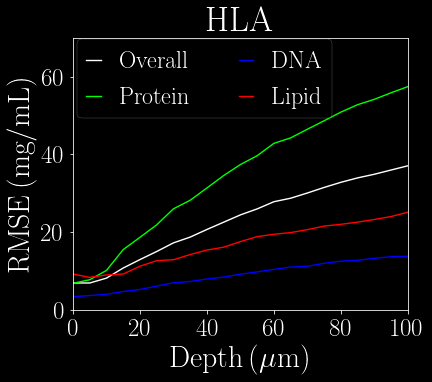

In [15]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(6,5))
depth_range = np.arange(0,105,5)
plt.plot(depth_range,RMSE,label = '$\mathrm{Overall}$',color='white')
plt.plot(depth_range,RMSE_Prot,label = '$\mathrm{Protein}$',color='lime')
plt.plot(depth_range,RMSE_DNA,label = '$\mathrm{DNA}$',color='blue')
plt.plot(depth_range,RMSE_lipid,label = '$\mathrm{Lipid}$',color='red')
plt.legend(fontsize=24,ncol =2,handlelength=0.6,bbox_to_anchor=(0.81,0.66))
plt.tick_params(labelsize=25)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.title('$\mathrm{HLA}$',fontsize=35)
plt.xlabel('$\mathrm{Depth\,(\mu m)}$',fontsize=30)
plt.ylabel('$\mathrm{RMSE\,(mg/mL)}$',fontsize=30)
plt.xlim((0,100))
plt.ylim((0,70))
fig.savefig('Black backg HLA RMSE performance depth.png',bbox_inches='tight',dpi=300)

In [16]:
mean_prot = np.mean(y[:,1])
mean_lipid = np.mean(y[:,2])
mean_DNA = np.mean(y[:,0])
mean_overall = np.mean(y)

print('Mean overall:',mean_overall,'mg/mL')
print('Mean DNA:',mean_DNA,'mg/mL')
print('Mean prot:',mean_prot,'mg/mL')
print('Mean lipid:',mean_lipid,'mg/mL')

Mean overall: 27.129166666666666 mg/mL
Mean DNA: 10.275 mg/mL
Mean prot: 49.6875 mg/mL
Mean lipid: 21.425 mg/mL


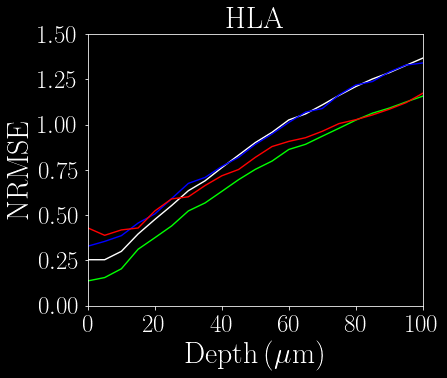

In [17]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(6,5))
depth_range = np.arange(0,105,5)
plt.plot(depth_range,np.array(RMSE)/mean_overall,label = '$\mathrm{Overall}$',color='white')
plt.plot(depth_range,np.array(RMSE_Prot)/mean_prot,label = '$\mathrm{Protein}$',color='lime')
plt.plot(depth_range,np.array(RMSE_DNA)/mean_DNA,label = '$\mathrm{DNA}$',color='blue')
plt.plot(depth_range,np.array(RMSE_lipid)/mean_lipid,label = '$\mathrm{Lipid}$',color='red')
#plt.legend(fontsize=19)
plt.tick_params(labelsize=25)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.xlabel('$\mathrm{Depth\,(\mu m)}$',fontsize=30)
plt.ylabel('$\mathrm{NRMSE}$',fontsize=30)
plt.title('$\mathrm{HLA}$',fontsize=30)
plt.xlim((0,100))
plt.ylim((0,1.5))
fig.savefig('Black back HLA NRMSE performance depth.png',bbox_inches='tight',dpi=300)

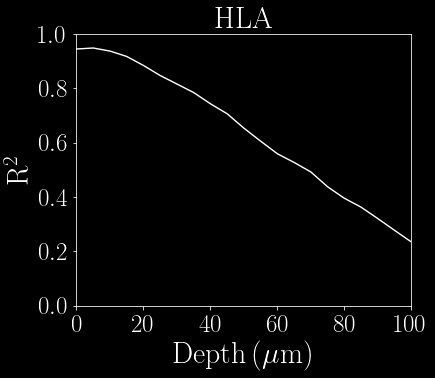

In [18]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(6,5))
plt.plot(depth_range,R2,color='white')
plt.tick_params(labelsize=20)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.title('$\mathrm{HLA}$',fontsize=30)
plt.xlabel('$\mathrm{Depth\,(\mu m)}$',fontsize=30)
plt.ylabel('$\mathrm{R^2}$',fontsize=30)
plt.tick_params(labelsize=25)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.xlim((0,100))
plt.ylim((0,1))
fig.savefig('Back backgr HLA R2 performance depth.png',bbox_inches='tight',dpi=300)

## Twin plot

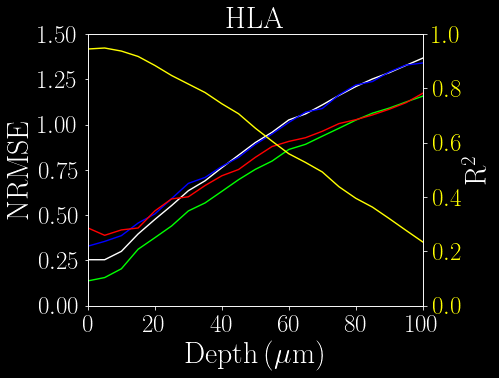

In [21]:
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(6,5))
ax2 = ax1.twinx()
depth_range = np.arange(0,105,5)
p1=ax1.plot(depth_range,np.array(RMSE)/mean_overall,label = '$\mathrm{Overall}$',color='white')
p2=ax1.plot(depth_range,np.array(RMSE_Prot)/mean_prot,label = '$\mathrm{Protein}$',color='lime')
p3=ax1.plot(depth_range,np.array(RMSE_DNA)/mean_DNA,label = '$\mathrm{DNA}$',color='blue')
p4=ax1.plot(depth_range,np.array(RMSE_lipid)/mean_lipid,label = '$\mathrm{Lipid}$',color='red')
ax1.tick_params(labelsize=25)
ax1.locator_params(axis='x', nbins=6)
ax1.locator_params(axis='y', nbins=6)
ax1.set_xlabel('$\mathrm{Depth\,(\mu m)}$',fontsize=30)
ax1.set_ylabel('$\mathrm{NRMSE}$',fontsize=30)
ax1.set_title('$\mathrm{HLA}$',fontsize=30)
ax1.set_xlim((0,100))
ax1.set_ylim((0,1.5))



p5 = ax2.plot(depth_range,R2,color='yellow',label ='$\mathrm{Overall R^2}$')
ax2.tick_params(labelsize=20)
ax2.locator_params(axis='x', nbins=6)
ax2.locator_params(axis='y', nbins=6)
ax2.set_ylabel('$\mathrm{R^2}$',fontsize=30)
ax2.tick_params(labelsize=25,labelcolor='yellow',axis='y')
ax2.set_ylim((0,1))

#fig.legend(bbox_to_anchor=(1.55, 1.25),fontsize = 24)
fig.savefig('blackgr opt wav HLA (NRMSE & R2).png',bbox_inches='tight',dpi=300)